## Load Data


In [1]:
!pip install opendatasets --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import necessary libraries
import opendatasets as od
import pandas as pd
import random
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from keras.models import Sequential
from keras.layers import Dense

In [3]:
dataset_url = 'https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'
od.download(dataset_url)
# {"username":"jeliao","key":"4d48f6ad6cc3d692b8a6015490d31bcf"}

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jeliao
Your Kaggle Key: ··········


100%|██████████| 1.56G/1.56G [00:19<00:00, 85.3MB/s]



Extracting archive ./new-york-city-taxi-fare-prediction/new-york-city-taxi-fare-prediction.zip to ./new-york-city-taxi-fare-prediction


In [4]:
#The dataset will be save in a folder called 'new-york-city-taxi-fare-prediction'. We save that folder as 'data_dir'.
data_dir = 'new-york-city-taxi-fare-prediction'

In [5]:
#Check the content of the folder and size of each file.
!dir -l {data_dir}

total 5564956
-rw-r--r-- 1 root root        486 Dec 20 03:50 GCP-Coupons-Instructions.rtf
-rw-r--r-- 1 root root     343271 Dec 20 03:50 sample_submission.csv
-rw-r--r-- 1 root root     983020 Dec 20 03:50 test.csv
-rw-r--r-- 1 root root 5697178298 Dec 20 03:51 train.csv


In [7]:
# Decide % of size we want to use. 
sample_frac = 0.1

In [8]:
%%time
selected_cols = 'fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count'.split(',')
dtypes = {
    'fare_amount': 'float32',
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'passenger_count': 'float32'
}

def skip_row(row_idx):
    if row_idx == 0:
        return False
    return random.random() > sample_frac

random.seed(29)
taxi_train = pd.read_csv(data_dir+'/train.csv', 
                 usecols=selected_cols, 
                 dtype=dtypes, 
                 parse_dates=['pickup_datetime'], 
                 skiprows=skip_row)

CPU times: user 14min 18s, sys: 8.66 s, total: 14min 26s
Wall time: 15min 22s


## Data Cleaning

In [9]:
taxi_train.head() 

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,9.0,2013-11-24 11:42:00+00:00,-73.957741,40.773617,-73.977089,40.758465,6.0
1,5.3,2011-03-04 18:12:00+00:00,-73.997040,40.737095,-73.986130,40.735043,1.0
2,5.0,2014-07-16 10:57:00+00:00,-73.996147,40.741890,-73.992203,40.739425,6.0
3,3.7,2010-01-31 10:53:00+00:00,-74.001633,40.730766,-73.997108,40.737533,1.0
4,7.7,2010-12-04 14:26:13+00:00,-73.996597,40.736568,-73.982155,40.744322,1.0


In [10]:
round(taxi_train.describe(), 2)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5545831.00,5545831.00,5545831.00,5545792.00,5545792.00,5545831.00
mean,11.33,-72.51,39.91,-72.51,39.92,1.69
std,9.78,12.76,9.98,12.99,9.91,1.33
min,-70.00,-3426.61,-3492.26,-3408.43,-3429.36,0.00
25%,6.00,-73.99,40.73,-73.99,40.73,1.00
50%,8.50,-73.98,40.75,-73.98,40.75,1.00
75%,12.50,-73.97,40.77,-73.96,40.77,2.00
max,1273.31,3454.85,3352.85,3211.58,3351.47,208.00


In [11]:
taxi_train.shape

(5545831, 7)

In [12]:
taxi_train.isnull().sum()

fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    39
dropoff_latitude     39
passenger_count       0
dtype: int64

In [13]:
taxi_train = taxi_train.dropna()

In [14]:
# remove data outlier
taxi_train = taxi_train.drop(taxi_train[taxi_train['pickup_longitude'] <= -75].index)
taxi_train = taxi_train.drop(taxi_train[taxi_train['pickup_longitude'] >= -72].index)
taxi_train = taxi_train.drop(taxi_train[taxi_train['dropoff_longitude'] <= -75].index)
taxi_train = taxi_train.drop(taxi_train[taxi_train['dropoff_longitude'] >= -72].index)
taxi_train = taxi_train.drop(taxi_train[taxi_train['pickup_latitude'] <= 40].index)
taxi_train = taxi_train.drop(taxi_train[taxi_train['pickup_latitude'] >= 42].index)
taxi_train = taxi_train.drop(taxi_train[taxi_train['dropoff_latitude'] <= 40].index)
taxi_train = taxi_train.drop(taxi_train[taxi_train['dropoff_latitude'] >= 42].index)

taxi_train = taxi_train.drop(taxi_train[taxi_train['fare_amount'] < 1].index)
taxi_train = taxi_train.drop(taxi_train[taxi_train['fare_amount'] > 500].index)
taxi_train = taxi_train.drop(taxi_train[taxi_train['passenger_count'] > 6].index)
taxi_train = taxi_train.drop(taxi_train[taxi_train['passenger_count'] < 1].index)

In [15]:
taxi_train.shape 

(5409799, 7)

## Feature Engineering

In [16]:
# Haversine Distance -- used to calculate great-circle distance given longitudes and latitudes.
def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return km

In [17]:
taxi_train['distance'] = haversine(taxi_train['pickup_longitude'], taxi_train['pickup_latitude'], 
                                   taxi_train['dropoff_longitude'], taxi_train['dropoff_latitude'])

In [18]:
# Extract parts of date
taxi_train['pickup_datetime'] = pd.to_datetime(taxi_train.pickup_datetime)
taxi_train['pickup_year'] = taxi_train['pickup_datetime'].dt.year
taxi_train['pickup_month'] = taxi_train['pickup_datetime'].dt.month
taxi_train['pickup_day'] = taxi_train['pickup_datetime'].dt.day
taxi_train['pickup_hour'] = taxi_train['pickup_datetime'].dt.hour
taxi_train['pickup_weekday'] = taxi_train['pickup_datetime'].dt.day_name()
taxi_train['pickup_day'] = taxi_train['pickup_datetime'].dt.dayofweek

In [19]:
# Base Fare --fares begin at $2.50 ($3.00 after 8:00 p.m., and $3.50 during the peak weekday hours of 4:00–8:00 p.m.)
conditions = [(taxi_train['pickup_hour'] >= 20) & (taxi_train['pickup_hour'] < 24),
            (taxi_train['pickup_hour'] >= 16) & (taxi_train['pickup_hour'] < 20) & (taxi_train['pickup_day'] >= 0) & (taxi_train['pickup_day'] <= 4)]
choices = [3,3.5]
taxi_train['base_fare'] = np.select(conditions, choices, default=2.5)

In [20]:
#Add distance from famous landmark
time_square_lonlat = -73.9855, 40.758
jfk_lonlat = -73.7781, 40.6413
statue_lonlat = -74.0445, 40.6892

def add_landmark_dropoff_distance(df, landmark_name, landmark_lonlat):
    lon, lat = landmark_lonlat
    df[landmark_name + '_distance'] = haversine(lon, lat, df['dropoff_longitude'], df['dropoff_latitude'])

def add_landmarks(a_df):
  landmarks = [('time_square', time_square_lonlat), ('jfk', jfk_lonlat),  ('statue', statue_lonlat)]
  for name, lonlat in landmarks:
    add_landmark_dropoff_distance(a_df, name, lonlat)

add_landmarks(taxi_train)

In [21]:
taxi_train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_weekday,base_fare,time_square_distance,jfk_distance,statue_distance
0,9.0,2013-11-24 11:42:00+00:00,-73.957741,40.773617,-73.977089,40.758465,6.0,2.342486,2013,11,6,11,Sunday,2.5,0.709867,21.226512,9.564284
1,5.3,2011-03-04 18:12:00+00:00,-73.997040,40.737095,-73.986130,40.735043,1.0,0.946365,2011,3,4,18,Friday,3.5,2.551654,20.391082,7.079799
2,5.0,2014-07-16 10:57:00+00:00,-73.996147,40.741890,-73.992203,40.739425,6.0,0.430317,2014,7,2,10,Wednesday,2.5,2.139922,21.079769,7.110075
3,3.7,2010-01-31 10:53:00+00:00,-74.001633,40.730766,-73.997108,40.737533,1.0,0.842717,2010,1,6,10,Sunday,2.5,2.475470,21.328510,6.691976
4,7.7,2010-12-04 14:26:13+00:00,-73.996597,40.736568,-73.982155,40.744322,1.0,1.490212,2010,12,5,14,Saturday,2.5,1.545802,20.655997,8.068041


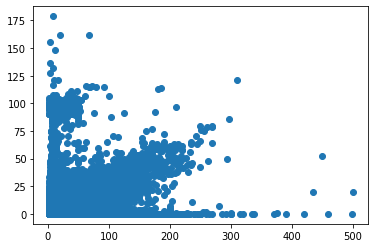

In [ ]:
plt.scatter(taxi_train['fare_amount'], taxi_train['distance']);

# Modeling

## Linear Regression

In [22]:
X = taxi_train.drop(columns = ['fare_amount', 'pickup_datetime', 'pickup_weekday'])
y = taxi_train['fare_amount']

In [23]:
# split the data into train and test
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [26]:
# Record the score between each model
scores = []

In [24]:
linear_model = LinearRegression(fit_intercept=True)
linear_model.fit(X_train, y_train)

LinearRegression()

In [27]:
yhat_train1 = linear_model.predict(X_train)
yhat_test1 = linear_model.predict(X_test)
print(linear_model.intercept_)
print(linear_model.coef_)
print('RMSE train:', mean_squared_error(y_train, yhat_train1, squared=False)) #RMSE
print('RMSE test:', mean_squared_error(y_test, yhat_test1, squared=False)) #RMSE
scores.append(mean_squared_error(y_test, yhat_test1, squared=False))

-3234.4663200340233
[ 2.12908628e+01 -2.04122938e+01 -6.15533963e+01  6.70011502e-01
  3.78764125e-02  1.82356136e+00  5.31963767e-01  7.44840776e-02
 -6.92237102e-02  2.35413324e-02 -4.16308207e-01  2.95986575e-01
 -4.31287866e-01  4.43497554e-01]
RMSE train: 5.258602718473786
RMSE test: 5.255952781787431


## Regression Tree

In [28]:
tree_model = DecisionTreeRegressor(max_leaf_nodes=7)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(max_leaf_nodes=7)

In [29]:
# draw tree model
import pydot
from IPython.display import Image
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)

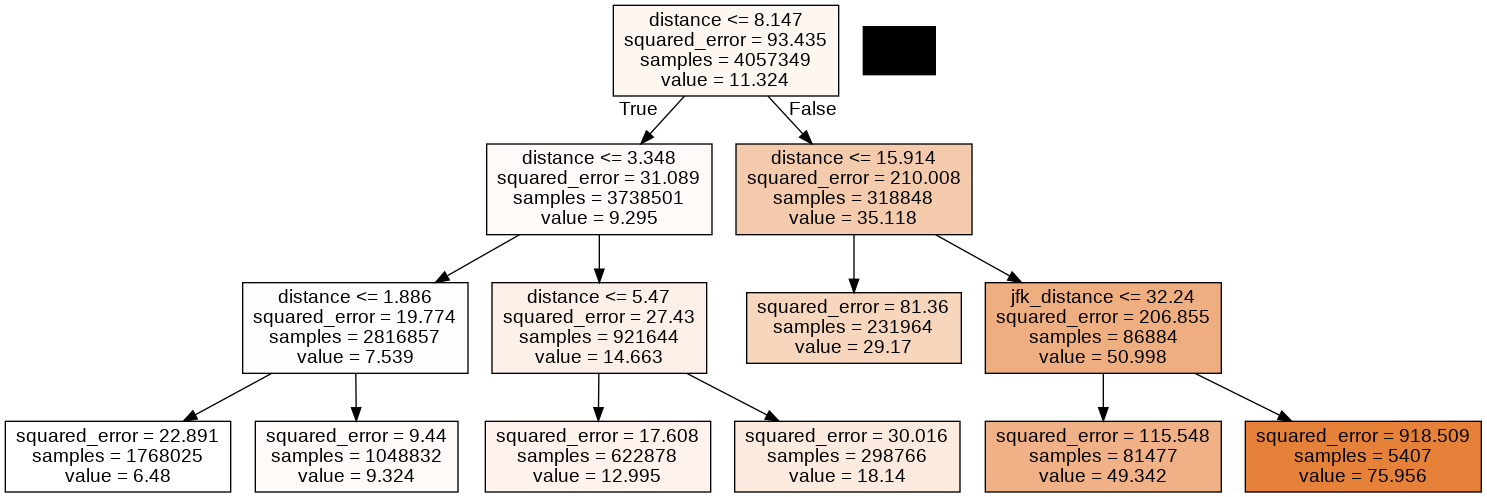

In [30]:
graph, = print_tree(tree_model, features=list(X.columns))
Image(graph.create_png())

In [31]:
yhat_train2 = tree_model.predict(X_train)
yhat_test2 = tree_model.predict(X_test)
print('RMSE train:', mean_squared_error(y_train, yhat_train2, squared=False)) #RMSE
print('RMSE test:', mean_squared_error(y_test, yhat_test2, squared=False)) #RMSE
scores.append(mean_squared_error(y_test, yhat_test2, squared=False))

RMSE train: 5.052195911036124
RMSE test: 5.010949867230955


## Random Forest

In [ ]:
rf_model = RandomForestRegressor(n_estimators=50, random_state=1, max_depth=10,  max_features=0.5, min_samples_leaf=3 )
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features=0.5, min_samples_leaf=3,
                      n_estimators=50, random_state=1)

In [ ]:
yhat_train3 = rf_model.predict(X_train)
yhat_test3 = rf_model.predict(X_test)
print('RMSE train:', mean_squared_error(y_train, yhat_train3, squared=False)) #RMSE
print('RMSE test:', mean_squared_error(y_test, yhat_test3, squared=False)) #RMSE
scores.append(mean_squared_error(y_test, yhat_test3, squared=False))

RMSE train: 3.784171139472436
RMSE test: 3.8406717411970512


                      Importance
distance               65.211016
time_square_distance   12.160013
pickup_longitude        8.822100
dropoff_longitude       3.167848
jfk_distance            2.486032
statue_distance         2.341849
pickup_latitude         2.318577
pickup_year             2.316698
dropoff_latitude        0.796617
pickup_hour             0.225404
pickup_month            0.088559
passenger_count         0.027171
pickup_day              0.025595
basic_fare              0.012522


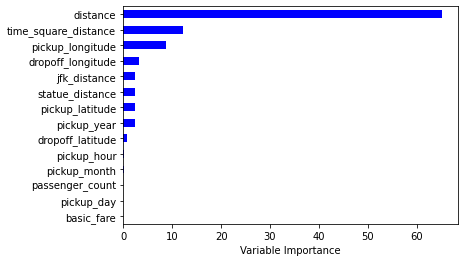

In [ ]:
# understand imprtance of each variable
Importance_ = pd.DataFrame({'Importance':rf_model.feature_importances_*100}, index=X_train.columns)
Importance = Importance_.sort_values('Importance', axis=0, ascending=False)[0:20]
Importance.plot(kind='barh', color='b', ).invert_yaxis()
print(Importance)
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

## Boosting

In [32]:
boost_model = GradientBoostingRegressor(n_estimators=50, learning_rate=0.05,random_state=1)
boost_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, n_estimators=50, random_state=1)

In [33]:
yhat_train4 = boost_model.predict(X_train)
yhat_test4 = boost_model.predict(X_test)
print('RMSE train:', mean_squared_error(y_train, yhat_train4, squared=False)) #RMSE
print('RMSE test:', mean_squared_error(y_test, yhat_test4, squared=False)) #RMSE
scores.append(mean_squared_error(y_test, yhat_test4, squared=False))

RMSE train: 4.4658470311211325
RMSE test: 4.4244386142635115


## Neural Network

In [ ]:
nn_model = Sequential()
nn_model.add(Dense(10, input_shape=(14, ), activation='relu', name='dense_1'))
nn_model.add(Dense(5, activation='relu', name='dense_2'))
nn_model.add(Dense(1, activation='linear', name='dense_output'))
nn_model.compile(optimizer='adam', loss='mse')
#https://keras.io/api/models/model_training_apis/
nn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 10)                150       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
 dense_output (Dense)        (None, 1)                 6         
                                                                 
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nn_model_fit = nn_model.fit(X_train, y_train, epochs=5, validation_split=0.05)

Epoch 1/5
120453/120453 [==============================] - 282s 2ms/step - loss: 33.5275 - val_loss: 26.9555
Epoch 2/5
120453/120453 [==============================] - 258s 2ms/step - loss: 24.4888 - val_loss: 25.1770
Epoch 3/5
120453/120453 [==============================] - 245s 2ms/step - loss: 24.0024 - val_loss: 24.3960
Epoch 4/5
120453/120453 [==============================] - 268s 2ms/step - loss: 23.6555 - val_loss: 25.2250
Epoch 5/5
120453/120453 [==============================] - 289s 2ms/step - loss: 23.5244 - val_loss: 24.0928


In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scattergl(y=nn_model_fit.history['loss'],
                    name='Train'))
fig.add_trace(go.Scattergl(y=nn_model_fit.history['val_loss'],
                    name='Valid'))
fig.update_layout(height=500, width=700,
                  xaxis_title='Epoch',
                  yaxis_title='Loss')
fig.show()

In [ ]:
yhat_train5 = nn_model.predict(X_train)
yhat_test5 = nn_model.predict(X_test)
print('RMSE train:', mean_squared_error(y_train, yhat_train5, squared=False)) #RMSE
print('RMSE test:', mean_squared_error(y_test, yhat_test5, squared=False)) #RMSE
scores.append(mean_squared_error(y_test, yhat_test5, squared=False))

42264/42264 [==============================] - 67s 2ms/step
RMSE train: 4.80866
RMSE test: 4.798139


In [ ]:
# Plot the predictions for each model
sns.set_style("white")
fig = plt.figure(figsize=(16, 8))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

## Predict Keggle Test DataSet

In [ ]:
taxi_test = pd.read_csv(data_dir+'/test.csv', dtype=dtypes, parse_dates=['pickup_datetime'])
taxi_test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1.0
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1.0
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746139,1.0
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751635,1.0
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1.0


In [ ]:
# generate features for test data
taxi_test['distance'] = haversine(taxi_test['pickup_longitude'], taxi_test['pickup_latitude'], 
                                   taxi_test['dropoff_longitude'], taxi_test['dropoff_latitude'])
taxi_test['pickup_datetime'] = pd.to_datetime(taxi_test.pickup_datetime)
taxi_test['pickup_year'] = taxi_test['pickup_datetime'].dt.year
taxi_test['pickup_month'] = taxi_test['pickup_datetime'].dt.month
taxi_test['pickup_day'] = taxi_test['pickup_datetime'].dt.day
taxi_test['pickup_hour'] = taxi_test['pickup_datetime'].dt.hour
taxi_test['pickup_day'] = taxi_test['pickup_datetime'].dt.dayofweek
conditions = [(taxi_test['pickup_hour'] >= 20) & (taxi_test['pickup_hour'] < 24),
            (taxi_test['pickup_hour'] >= 16) & (taxi_test['pickup_hour'] < 20) & (taxi_test['pickup_day'] >= 0) & (taxi_test['pickup_day'] <= 4)]
choices = [3,3.5]
taxi_test['basic_fare'] = np.select(conditions, choices, default=2.5)
add_landmarks(taxi_test)

In [ ]:
taxi_X_test = taxi_test.drop(columns = ['key', 'pickup_datetime'])

In [ ]:
taxi_test_predict = rf_model.predict(taxi_X_test)

In [ ]:
submit = pd.DataFrame(taxi_test['key'])
submit

,key
0,2015-01-27 13:08:24.0000002
1,2015-01-27 13:08:24.0000003
2,2011-10-08 11:53:44.0000002
3,2012-12-01 21:12:12.0000002
4,2012-12-01 21:12:12.0000003
...,...
9909,2015-05-10 12:37:51.0000002
9910,2015-01-12 17:05:51.0000001
9911,2015-04-19 20:44:15.0000001
9912,2015-01-31 01:05:19.0000005


In [ ]:
submit['fare_amount'] = taxi_test_predict
submit

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.034996
1,2015-01-27 13:08:24.0000003,10.035498
2,2011-10-08 11:53:44.0000002,5.532277
3,2012-12-01 21:12:12.0000002,8.189609
4,2012-12-01 21:12:12.0000003,13.997590
...,...,...
9909,2015-05-10 12:37:51.0000002,8.737504
9910,2015-01-12 17:05:51.0000001,11.934103
9911,2015-04-19 20:44:15.0000001,54.919295
9912,2015-01-31 01:05:19.0000005,22.864087


In [ ]:
submit.to_csv('rf_submission.csv', index=False)